# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [1]:
# Install the required libraries
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [3]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

<ipython-input-3-217fb1a948ac>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [4]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


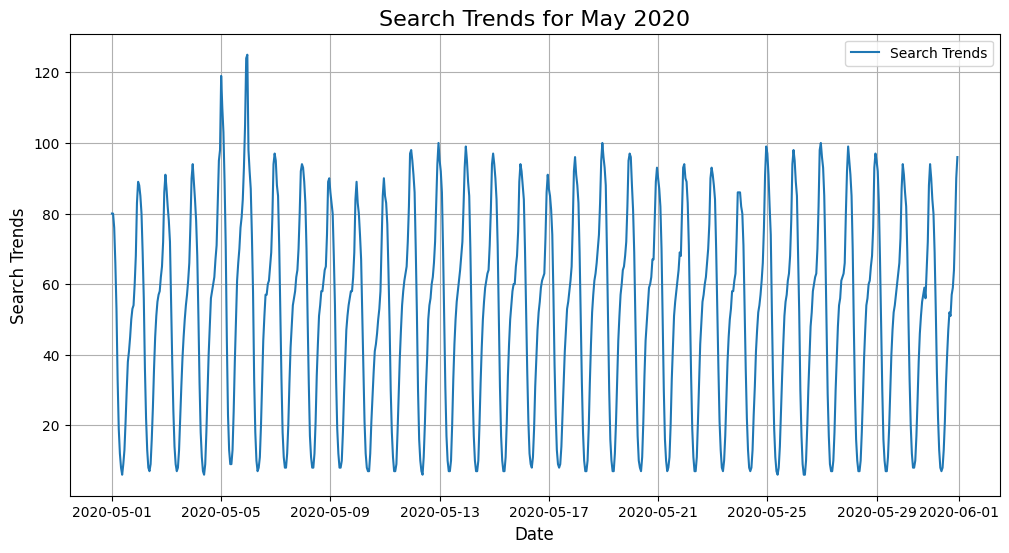

In [5]:
# Slice the DataFrame to just the month of May 2020
may_2020_data = df_mercado_trends.loc['2020-05']

# Plot the data for May 2020
plt.figure(figsize=(12, 6))
plt.plot(may_2020_data.index, may_2020_data['Search Trends'], label='Search Trends')

# Add titles and labels
plt.title('Search Trends for May 2020', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Search Trends', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [6]:
# Calculate the sum of the total search traffic for May 2020
total_search_trends_may_2020 = may_2020_data['Search Trends'].sum()


# View the traffic_may_2020 value
print(f"May 2020 Search Trend: {total_search_trends_may_2020}")
type(total_search_trends_may_2020)

May 2020 Search Trend: 38181


numpy.int64

In [7]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
median_monthly_traffic = (
    df_mercado_trends['Search Trends']  # Select the column
    .resample('ME')                      # Resample by month
    .sum()                              # Calculate monthly totals
    .median()                           # Compute the median of monthly totals
)

# View the median_monthly_traffic value
print(f"Median Monthly Search Trends: {median_monthly_traffic}")
type(median_monthly_traffic)

Median Monthly Search Trends: 35172.5


float

In [8]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
total_search_trends_may_2020/median_monthly_traffic

1.0855355746677091

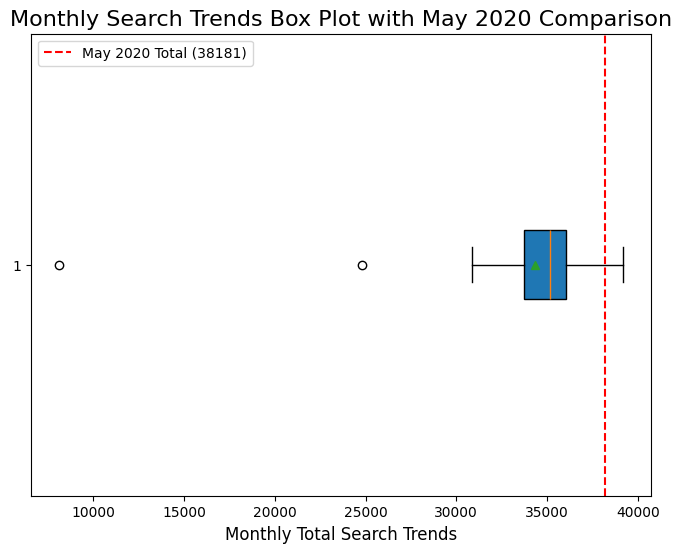

May 2020 total (38181) is within the IQR range (30235.875, 39564.875).


In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Calculate monthly totals
monthly_totals = (
    df_mercado_trends['Search Trends']  # Select the column
    .resample('ME')                      # Resample by month
    .sum()                              # Calculate monthly totals
)

# Step 2: Calculate the total for May 2020
may_2020_total = may_2020_data['Search Trends'].sum()

# Step 3: Plot the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(monthly_totals, vert=False, patch_artist=True, showmeans=True)
plt.axvline(may_2020_total, color='red', linestyle='--', label=f'May 2020 Total ({may_2020_total})')

# Add labels and title
plt.title('Monthly Search Trends Box Plot with May 2020 Comparison', fontsize=16)
plt.xlabel('Monthly Total Search Trends', fontsize=12)
plt.legend()
plt.show()

# Step 4: Check if May 2020 data is outside the IQR
Q1 = monthly_totals.quantile(0.25)  # First quartile
Q3 = monthly_totals.quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print results
if may_2020_total < lower_bound or may_2020_total > upper_bound:
    print(f"May 2020 total ({may_2020_total}) is outside the IQR range ({lower_bound}, {upper_bound}).")
else:
    print(f"May 2020 total ({may_2020_total}) is within the IQR range ({lower_bound}, {upper_bound}).")


##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** The Google seach traffic for MercadoLibre increased by 8.6% in the month of May 2020, the same month the company released its financial results, but is not significantly different for any month.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

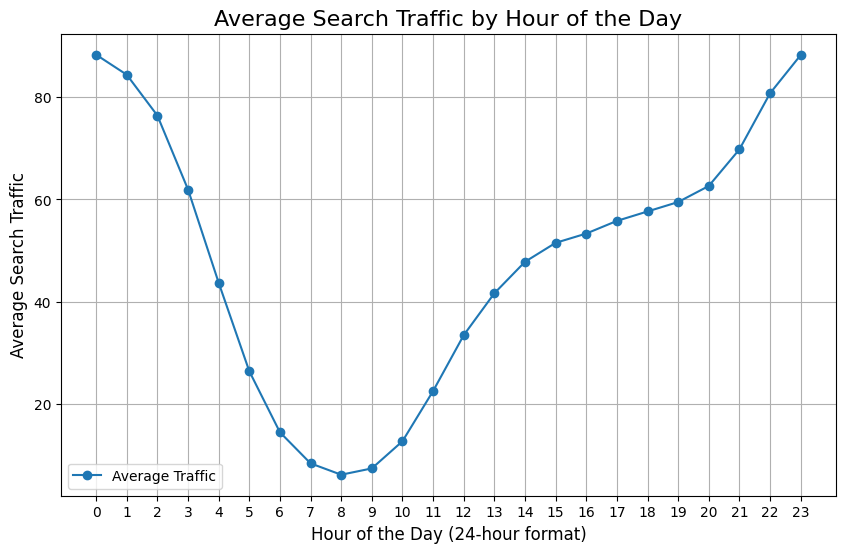

In [10]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
# Group the data by the day of the week and calculate the average traffic
average_traffic_by_hour = df_mercado_trends.groupby(df_mercado_trends.index.hour)['Search Trends'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(average_traffic_by_hour.index, average_traffic_by_hour.values, marker='o', label='Average Traffic')

# Customize the plot
plt.title('Average Search Traffic by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day (24-hour format)', fontsize=12)
plt.ylabel('Average Search Traffic', fontsize=12)
plt.xticks(range(0, 24))  # Set x-axis ticks for each hour
plt.grid(True)
plt.legend()
plt.show()

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

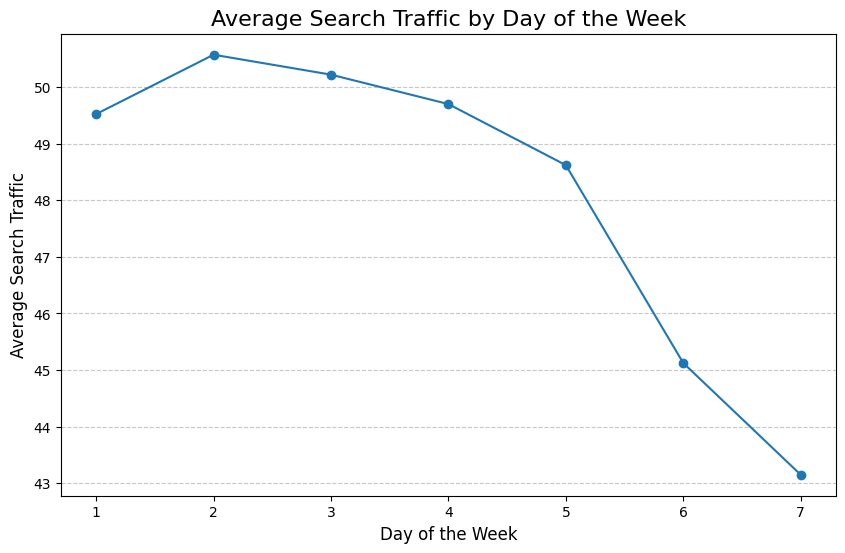

In [11]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
# Group the data by the day of the week and calculate the average traffic
average_traffic_by_day = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().day)['Search Trends'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(average_traffic_by_day.index, average_traffic_by_day.values, marker='o', label='Average Traffic')

# Customize the plot
plt.title('Average Search Traffic by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Search Traffic', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

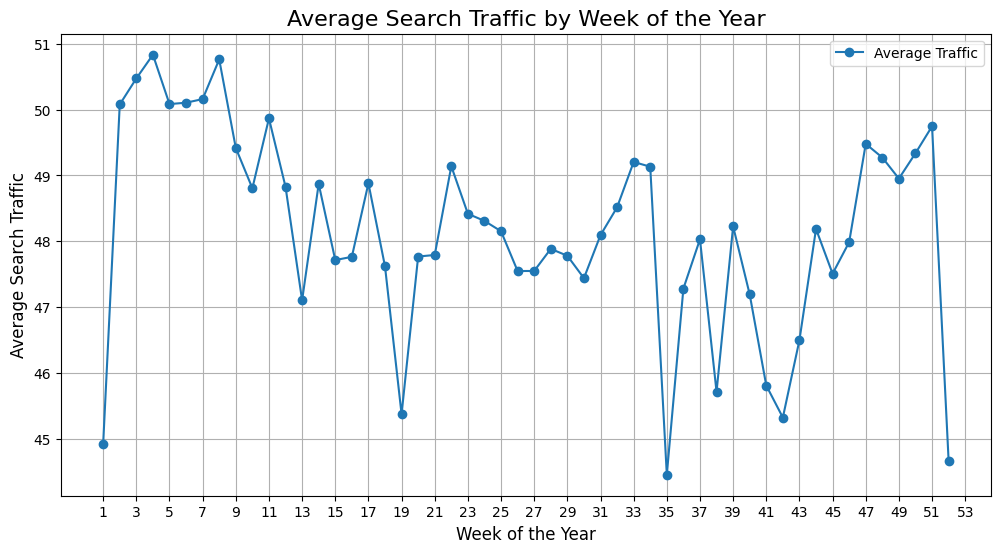

In [12]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
# Group the data by week of the year and calculate the average traffic
average_traffic_by_week = (
    df_mercado_trends
    .groupby(df_mercado_trends.index.isocalendar().week)['Search Trends']
    .mean()
)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(average_traffic_by_week.index, average_traffic_by_week.values, marker='o', label='Average Traffic')

# Customize the plot
plt.title('Average Search Traffic by Week of the Year', fontsize=16)
plt.xlabel('Week of the Year', fontsize=12)
plt.ylabel('Average Search Traffic', fontsize=12)
plt.xticks(range(1, 54, 2))  # Set x-axis ticks for every second week
plt.grid(True)
plt.legend()
plt.show()

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:**  On an average day, searches for MercadoLibre peak around 23:00 to 00:00 and are lowest at 08:00 (no time zone established).  On average, Tuesday has the highest number of searches while Sunday has the least.  Although there are a few weeks during the year that searches slow down, the only clear trend is that the lowest rate of searches is during the Christmas/New Years holiday season.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [13]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


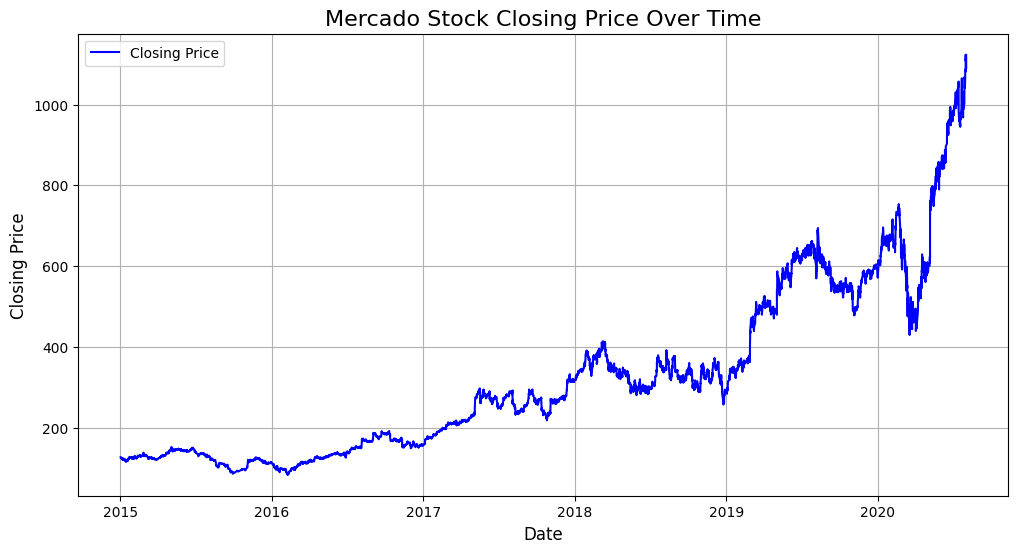

In [14]:
# Visualize the closing price of the df_mercado_stock DataFrame
plt.figure(figsize=(12, 6))
plt.plot(df_mercado_stock.index, df_mercado_stock['close'], label='Closing Price', color='blue')

# Customize the plot
plt.title('Mercado Stock Closing Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
# To avoid confusion, naming the new concatenated df as df_combined
df_combined = pd.concat([df_mercado_stock, df_mercado_trends], axis=1)

# Drop rows where data exists in only one of the DataFrames
df_combined = df_combined.dropna(how='any')

# View the first and last five rows of the DataFrame
print(df_combined.head())
print(df_combined.tail())

                      close  Search Trends
2016-06-01 09:00:00  135.16            6.0
2016-06-01 10:00:00  136.63           12.0
2016-06-01 11:00:00  136.56           22.0
2016-06-01 12:00:00  136.42           33.0
2016-06-01 13:00:00  136.10           40.0
                        close  Search Trends
2020-07-31 11:00:00  1105.780           20.0
2020-07-31 12:00:00  1087.925           32.0
2020-07-31 13:00:00  1095.800           41.0
2020-07-31 14:00:00  1110.650           47.0
2020-07-31 15:00:00  1122.510           53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [16]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
df_first_half_2020 = df_combined.loc['2020-01':'2020-06']


# View the first and last five rows of first_half_2020 DataFrame
print(df_first_half_2020.head())
print(df_first_half_2020.tail())


                       close  Search Trends
2020-01-02 09:00:00  601.085            9.0
2020-01-02 10:00:00  601.290           14.0
2020-01-02 11:00:00  615.410           25.0
2020-01-02 12:00:00  611.400           37.0
2020-01-02 13:00:00  611.830           50.0
                      close  Search Trends
2020-06-30 11:00:00  976.17           17.0
2020-06-30 12:00:00  977.50           27.0
2020-06-30 13:00:00  973.23           37.0
2020-06-30 14:00:00  976.50           45.0
2020-06-30 15:00:00  984.93           51.0


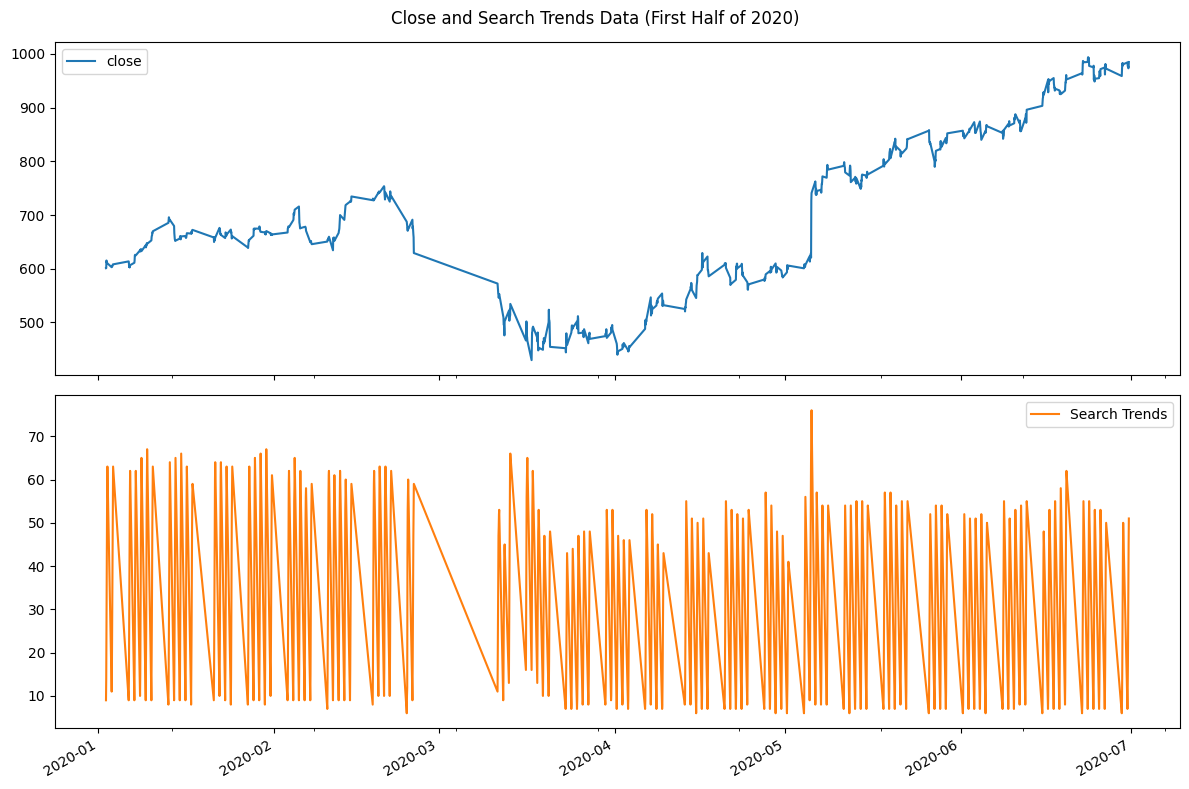

In [17]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
df_first_half_2020[['close', 'Search Trends']].plot(
    subplots=True,  # Plot each column on a separate subplot
    figsize=(12, 8),  # Set the figure size
    title="Close and Search Trends Data (First Half of 2020)"
)

# Show the plots
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** Overall there does not appear to be strong trending between MercadoLibre search trends and the closing price of the company's stock.  However, there is one day in May where there was an increase in search activity that correlated with an increase in company's stock price.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [18]:
# Expand table width for display
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)       # Allow the table to use the full width of the console

In [19]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# Using df_combined instead of mercado_stock_trends_df
# This column should shift the Search Trends information by one hour
df_combined['Lagged Search Trends'] = df_combined['Search Trends'].shift(1)


In [20]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# Using df_combined instead of mercado_stock_trends_df
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
# Calculate the percentage change in the 'close' column (stock price returns)
df_combined['Stock Returns'] = df_combined['close'].pct_change()

# Calculate the rolling standard deviation over a 4-period window
df_combined['Stock Volatility'] = df_combined['Stock Returns'].rolling(window=4).std()


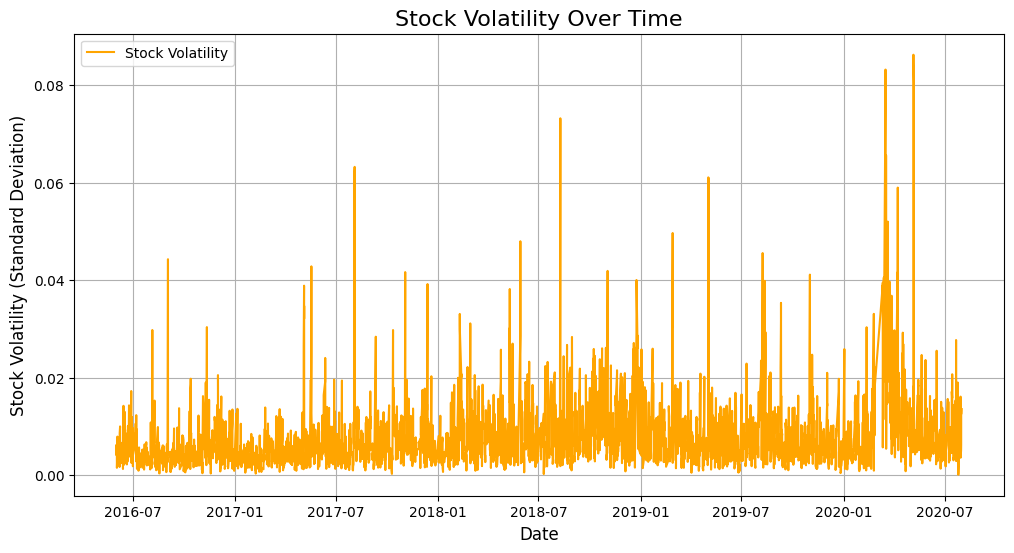

In [21]:
# Visualize the stock volatility
plt.figure(figsize=(12, 6))
plt.plot(df_combined.index, df_combined['Stock Volatility'], label='Stock Volatility', color='orange')

# Add titles and labels
plt.title('Stock Volatility Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Volatility (Standard Deviation)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [22]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# Using df_combined instead of mercado_stock_trends_df
# This column should calculate hourly return percentage of the closing price
df_combined['Hourly Stock Return'] = df_combined['close'].pct_change() * 100



In [23]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
# Using df_combined instead of mercaod_stock_trends_df
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
print(df_combined.head())
print(df_combined.tail())


                      close  Search Trends  Lagged Search Trends  Stock Returns  Stock Volatility  Hourly Stock Return
2016-06-01 09:00:00  135.16            6.0                   NaN            NaN               NaN                  NaN
2016-06-01 10:00:00  136.63           12.0                   6.0       0.010876               NaN             1.087600
2016-06-01 11:00:00  136.56           22.0                  12.0      -0.000512               NaN            -0.051233
2016-06-01 12:00:00  136.42           33.0                  22.0      -0.001025               NaN            -0.102519
2016-06-01 13:00:00  136.10           40.0                  33.0      -0.002346          0.006134            -0.234570
                        close  Search Trends  Lagged Search Trends  Stock Returns  Stock Volatility  Hourly Stock Return
2020-07-31 11:00:00  1105.780           20.0                  11.0       0.006380          0.012837             0.637986
2020-07-31 12:00:00  1087.925           32.0

#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [24]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
df_combined[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** No, the correlation values between lagged search taffic and both stock volatitliy and stock price resturns are close to zero which indicates a poor relationship between them.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [27]:
df_mercado_trends

,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38
...,...
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96


In [29]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
prophet_df = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
prophet_df = prophet_df.rename(columns={
    'Date': 'ds',            # Rename the date column named 'index' to 'ds'
    'Search Trends': 'y'     # Rename the target variable column to 'y'
})

# Drop an NaN values from the prophet_df DataFrame
prophet_df = prophet_df.dropna()

# Keep only the 'ds' and 'y' columns
prophet_df = prophet_df[['ds', 'y']]

# View the first and last five rows of the mercado_prophet_df DataFrame
print(prophet_df.head())
print(prophet_df.tail())


                   ds   y
0 2016-06-01 00:00:00  97
1 2016-06-01 01:00:00  92
2 2016-06-01 02:00:00  76
3 2016-06-01 03:00:00  60
4 2016-06-01 04:00:00  38
                       ds   y
37101 2020-09-07 20:00:00  71
37102 2020-09-07 21:00:00  83
37103 2020-09-07 22:00:00  96
37104 2020-09-07 23:00:00  97
37105 2020-09-08 00:00:00  96


In [30]:
# Call the Prophet function, store as an object
model = Prophet()
print(model)

In [31]:
# Fit the time-series model.
model.fit(prophet_df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpccckfdn_/zexutwqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpccckfdn_/3u4_8olb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58368', 'data', 'file=/tmp/tmpccckfdn_/zexutwqy.json', 'init=/tmp/tmpccckfdn_/3u4_8olb.json', 'output', 'file=/tmp/tmpccckfdn_/prophet_modelteewr0vy/prophet_model-20250118231231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:12:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:12:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [32]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future = model.make_future_dataframe(periods=2000, freq='h')

# View the last five rows of the future_mercado_trends DataFrame
# Using the prophet_df created earlier.
print(future.tail())


                       ds
39101 2020-11-30 04:00:00
39102 2020-11-30 05:00:00
39103 2020-11-30 06:00:00
39104 2020-11-30 07:00:00
39105 2020-11-30 08:00:00


In [33]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast = model.predict(future)

# Display the first five rows of the forecast_mercado_trends DataFrame
forecast.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.469500,81.052711,97.486825,44.469500,44.469500,45.159722,45.159722,45.159722,41.452703,41.452703,41.452703,1.860594,1.860594,1.860594,1.846426,1.846426,1.846426,0.0,0.0,0.0,89.629222
1,2016-06-01 01:00:00,44.470406,78.004919,94.870002,44.470406,44.470406,41.605529,41.605529,41.605529,37.943556,37.943556,37.943556,1.810498,1.810498,1.810498,1.851474,1.851474,1.851474,0.0,0.0,0.0,86.075935
2,2016-06-01 02:00:00,44.471312,67.154212,84.290662,44.471312,44.471312,31.282049,31.282049,31.282049,27.656646,27.656646,27.656646,1.768912,1.768912,1.768912,1.856491,1.856491,1.856491,0.0,0.0,0.0,75.753361
3,2016-06-01 03:00:00,44.472218,52.239904,68.616850,44.472218,44.472218,16.014826,16.014826,16.014826,12.417424,12.417424,12.417424,1.735926,1.735926,1.735926,1.861476,1.861476,1.861476,0.0,0.0,0.0,60.487045
4,2016-06-01 04:00:00,44.473124,35.243848,52.637677,44.473124,44.473124,-1.100073,-1.100073,-1.100073,-4.677999,-4.677999,-4.677999,1.711496,1.711496,1.711496,1.866430,1.866430,1.866430,0.0,0.0,0.0,43.373051


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

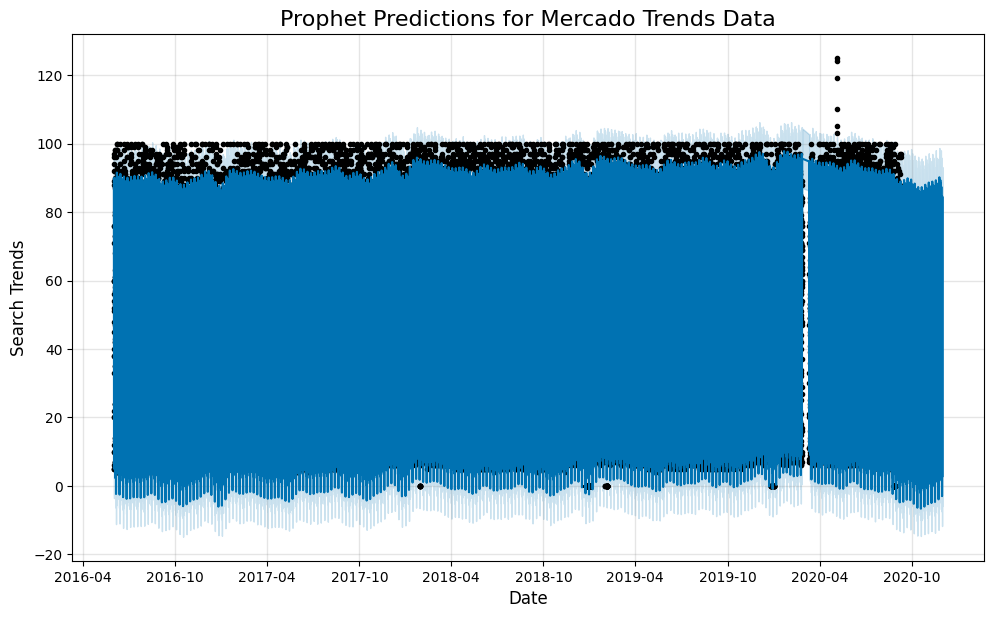

In [34]:
# Plot the Prophet predictions for the Mercado trends data
fig = model.plot(forecast)
plt.title("Prophet Predictions for Mercado Trends Data", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Search Trends", fontsize=12)
plt.grid(True)
plt.show()


##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** The near-term forecast for popularity of MercadoLibre is predicted to decrease slightly.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [35]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast = forecast.set_index('ds')


# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
forecast[['yhat', 'yhat_lower', 'yhat_upper']].head(5)


,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.629222,81.052711,97.486825
2016-06-01 01:00:00,86.075935,78.004919,94.870002
2016-06-01 02:00:00,75.753361,67.154212,84.290662
2016-06-01 03:00:00,60.487045,52.239904,68.616850
2016-06-01 04:00:00,43.373051,35.243848,52.637677


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

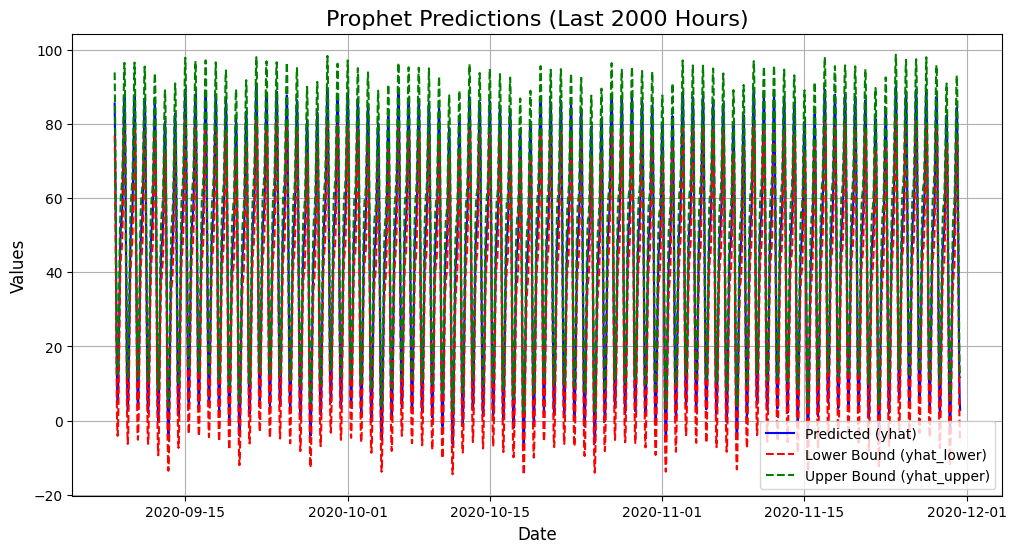

In [36]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
# Not sure why the index was reset to ds in previous step.  Resetting index so that ds can be used in plot
forecast = forecast.reset_index()

forecast_last_2000 = forecast.tail(2000)
plt.figure(figsize=(12, 6))
plt.plot(forecast_last_2000['ds'], forecast_last_2000['yhat'], label='Predicted (yhat)', color='blue')
plt.plot(forecast_last_2000['ds'], forecast_last_2000['yhat_lower'], label='Lower Bound (yhat_lower)', color='red', linestyle='dashed')
plt.plot(forecast_last_2000['ds'], forecast_last_2000['yhat_upper'], label='Upper Bound (yhat_upper)', color='green', linestyle='dashed')

# Customize the plot
plt.title('Prophet Predictions (Last 2000 Hours)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

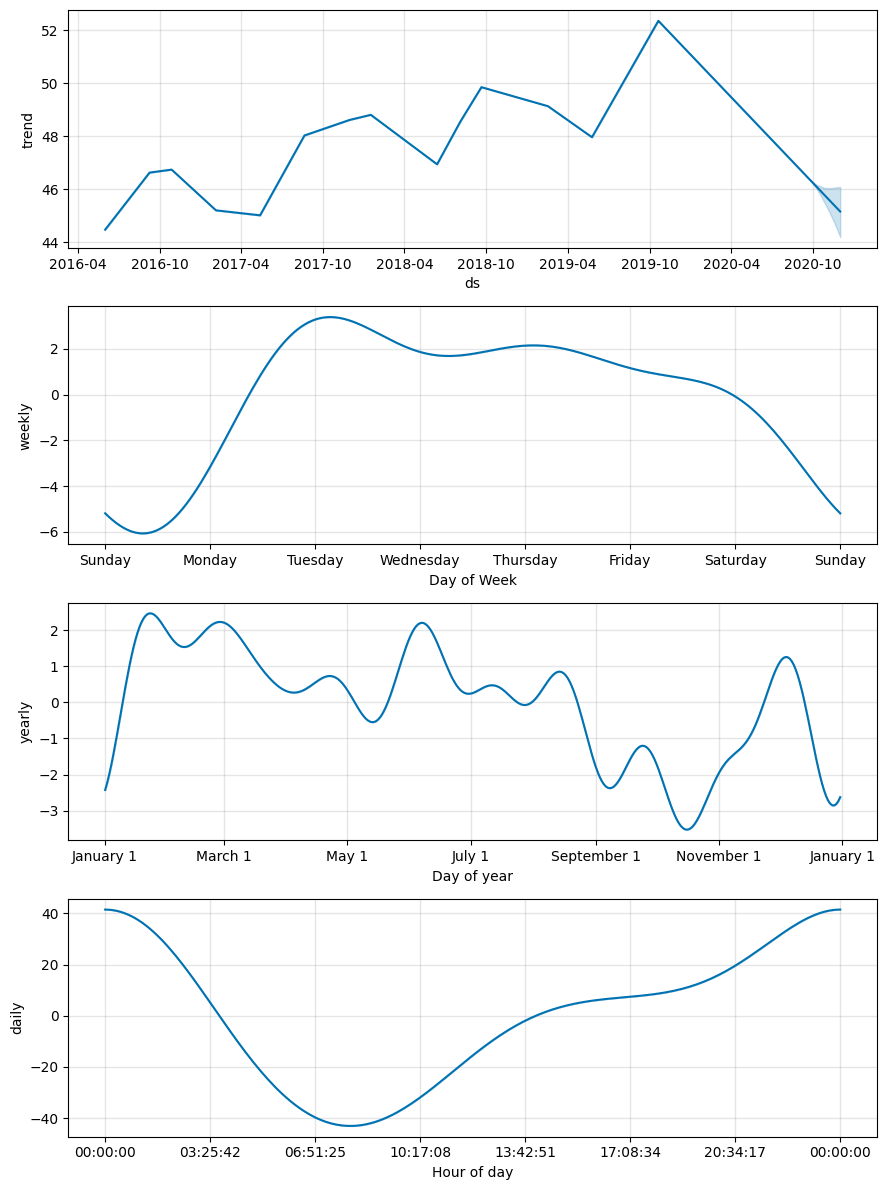

In [37]:
# Reset the index in the forecast_mercado_trends DataFrame


# Use the plot_components function to visualize the forecast results
# for the forecast_mercado_trends DataFrame
model.plot_components(forecast)
plt.show()


##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** Midnight is the time of day with the greatest search history for MercadoLibre.

**Question:** Which day of week gets the most search traffic?
   
**Answer:** Tuesday is the day of the week with the highest search traffic for MercadoLibre.

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** Mid-October is the lowest point for MercadoLibre search traffic during the calendar year.
